In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px

df = pd.read_csv('../input/train.csv')
df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [18]:
def transform(frame):
    df = frame.copy()
    df[['Group','GroupMember']] = df['PassengerId'].str.split('_', expand=True)
    df[['Deck','Room','Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(columns=['Age','Name','Cabin'])

    spending_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    # If they spent anything, they probably aren't in cryosleep
    df.loc[(df.CryoSleep.isna()) & (df[spending_cols].sum(axis=1) > 0), 'CryoSleep'] = False
    # If they didn't spend anything, they probably are in cryosleep
    df.loc[(df.CryoSleep.isna()) & (df[spending_cols].sum(axis=1) == 0), 'CryoSleep'] = True


    ###
    # TODO: Relocate Imputers for use with split data
    ### 

    # Some columns we will just assume the most common value
    simple_cols = ['HomePlanet', 'VIP']
    # Train the imputer
    from sklearn.impute import SimpleImputer
    simple_imputer = SimpleImputer(strategy='most_frequent')
    simple_imputer.fit(df[simple_cols])

    imputed_values = simple_imputer.transform(df[simple_cols])
    df[simple_cols] = imputed_values

    # Handle nulls for spending data
    # Using the same from Cryosleep we can cut out some nulls from all of the spending columns
    df.loc[df.CryoSleep == True, spending_cols] = 0.0

    # Fit on training data
    from sklearn.impute import KNNImputer
    spending_imputer = KNNImputer()
    spending_imputer.fit(df[spending_cols])
    # Assign predictions back to the original DataFrame
    imputed_spending_values = spending_imputer.transform(df[spending_cols])
    df.loc[:, spending_cols] = imputed_spending_values

    return df

transform(df).isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Destination     182
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Group             0
GroupMember       0
Deck            199
Room            199
Side            199
dtype: int64

In [28]:
dfalt = transform(df)
dfalt = dfalt.drop(columns='Destination')
dfalt = dfalt.dropna()

In [29]:
dfalt['Group'] = dfalt['Group'].astype(int)
dfalt['GroupMember'] = dfalt['GroupMember'].astype(int)
dfalt['Room'] = dfalt['Room'].astype(int)

In [30]:
dfalt.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Group             int32
GroupMember       int32
Deck             object
Room              int32
Side             object
dtype: object

In [31]:
dfalt.head()

,PassengerId,HomePlanet,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupMember,Deck,Room,Side
0,0001_01,Europa,False,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,0002_01,Earth,False,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,0003_01,Europa,False,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S
3,0003_02,Europa,False,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,0004_01,Earth,False,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


<AxesSubplot:xlabel='Group', ylabel='Room'>

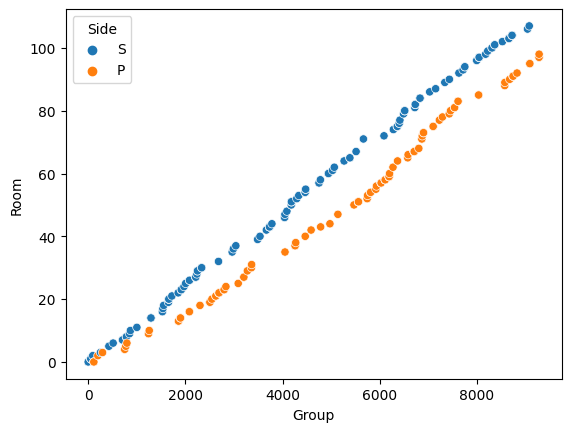

In [34]:
sns.scatterplot(data=dfalt[dfalt['Deck'] == 'A'], x='Group', y='Room', hue='Side')